## 掛載雲端硬碟


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## 更改檔案所在路徑

In [ ]:
# 更改為我的資料目錄
%cd /home/twccjq88/2025EAI_Project/EAI_Lab2

/home/twccjq88/2025EAI_Project/EAI_Lab2


## Import library

In [6]:
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models.resnet import ResNet50

## FLOPs & Parameters & Architecture
若`resnet.py`有寫對，這部分會能夠正常跑，且 parameters 應為 23513162。

你也可以寫一個剪枝後可能的 cfg 作為模型的輸入參數，看這部分印出來的架構是否正確。

In [7]:
!pip install thop
!pip install torchsummary

In [8]:
from thop import profile
from torchsummary import summary

model = ResNet50(num_classes=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))

print(f"FLOPs: {flops}")
print(f"Params: {params}")
summary(model, input_size=(3, 32, 32))

Device: cuda
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 329193472.0
Params: 23513162.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]          

## 設定超參數(請填空 λ)

In [9]:
SPARSITY_REGULARIZATION = True
#### 設定λ(balance factor) ####
################################################
#          請填空          #
################################################
LAMBDA = 1e-4  # 題目要求: λ = 1e-4 進行稀疏正則化訓練

SEED = 1
# 優化: 雙顯卡訓練,適度增加 batch size
TRAIN_BATCH_SIZE = 256  # 原本 100 → 256 (雙 V100: 每張卡 128)
TEST_BATCH_SIZE = 1000

EPOCHS = 40
# 優化: 稀疏訓練對學習率敏感,使用保守的縮放 (sqrt scaling)
LEARNING_RATE = 1.6e-3  # 原本 1e-3 → 1.6e-3 (sqrt(256/100) ≈ 1.6)

LOG_INTERVAL = 100
CUDA = True

RESUME = False
START_EPOCH = 0

WEIGHT_PATH = '/home/twccjq88/2025EAI_Project/EAI_Lab2/checkpoints/model_lambda_1e-4.pth'  # λ=1e-4 訓練模型保存路徑

In [10]:
# Create directory for saving figures
FIGURE_DIR = 'figures'  # Folder to save figures
os.makedirs(FIGURE_DIR, exist_ok=True)
print(f"Figures will be saved to: {FIGURE_DIR}/")


Figures will be saved to: figures/


In [11]:
if torch.cuda.is_available():
    CUDA = True
    cuda_count = torch.cuda.device_count()
    device_names = [torch.cuda.get_device_name(i) for i in range(cuda_count)]
    print(f"✓ Detected {cuda_count} GPU(s): {device_names}")
    
    # Optimization: Increase num_workers for dual-GPU
    kwargs = {'num_workers': 8, 'pin_memory': True, 'prefetch_factor': 2}
    torch.cuda.manual_seed(SEED)
    
    if cuda_count > 1:
        print("✓ Using DataParallel for multi-GPU training")
else:
    CUDA = False
    kwargs = {}


✓ Detected 2 GPU(s): ['Tesla V100-SXM2-32GB', 'Tesla V100-SXM2-32GB']
✓ Using DataParallel for multi-GPU training


## 下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [12]:
#### 資料集 ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

Files already downloaded and verified


## 定義模型與設定Optimizer & CrossEntropy Loss


In [13]:
model = ResNet50(num_classes=10)
if CUDA:
    model = model.cuda()
    # Multi-GPU support
    if torch.cuda.device_count() > 1:
        print(f"✓ Using {torch.cuda.device_count()} GPUs for training")
        model = nn.DataParallel(model)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

✓ Using 2 GPUs for training


In [14]:
# Check multi-GPU setup
print("="*70)
print("🔍 Checking multi-GPU setup")
print("="*70)
print(f"Model type: {type(model)}")
print(f"Using DataParallel: {isinstance(model, nn.DataParallel)}")
if isinstance(model, nn.DataParallel):
    print(f"✓ DataParallel is enabled, using {len(model.device_ids)} GPUs: {model.device_ids}")
else:
    print("⚠ Warning: DataParallel is not enabled, using single GPU only")
    if torch.cuda.device_count() > 1:
        print("  Suggestion: Rerun the previous cell to enable multi-GPU support")
print("="*70)


🔍 Checking multi-GPU setup
Model type: <class 'torch.nn.parallel.data_parallel.DataParallel'>
Using DataParallel: True
✓ DataParallel is enabled, using 2 GPUs: [0, 1]


## 使用論文中稀疏化的方式更新參數(請填空)

In [ ]:
def updateBN():
  for m in model.modules():
      if isinstance(m, nn.BatchNorm2d):
          #### 完成Sparsity Regularization ####
          ################################################
          #          請填空          #
          if m.weight is not None and m.weight.grad is not None:
              m.weight.grad.data.add_(LAMBDA * torch.sign(m.weight.data))
          ################################################
          # 對 BatchNorm 的 gamma (weight) 參數添加 L1 正則化梯度
          # 只對有梯度的參數進行正則化（跳過 affine=False 的層）
          



## 定義訓練跟測試函數
需自行撰寫儲存每個epoch之train acc與test acc的code，以便後續繪製train acc與test acc結果圖!

In [16]:
#### 訓練函數 #####

# 注意: 需自行撰寫儲存每個epoch之train acc與test acc的code，以便後續繪製train acc與test acc結果圖!

def train(epoch):
    """
    Train for one epoch
    Returns: train accuracy, train loss
    """
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        # Forward pass
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass with sparsity regularization
        loss.backward()
        if SPARSITY_REGULARIZATION:
            updateBN()  # Apply L1 regularization to BN scaling factors
        optimizer.step()

        # Accumulate metrics
        train_loss += loss.item() * data.size(0)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        total += target.size(0)

    # Calculate epoch metrics
    train_acc = correct.item() / float(total)
    avg_loss = train_loss / total
    
    return train_acc, avg_loss



#### 測試函數 ####
def test(epoch):
    """
    Evaluate on test set
    Returns: test accuracy, test loss
    """
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            if CUDA:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)

            output = model(data)
            loss = criterion(output, target)
            
            test_loss += loss.item() * data.size(0)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            total += target.size(0)

    # Calculate test metrics
    test_acc = correct.item() / float(total)
    avg_loss = test_loss / total
    
    return test_acc, avg_loss


# ==================== Training Loop ====================
print("="*70)
print("Starting Sparsity Training with Network Slimming")
print(f"Lambda: {LAMBDA}, Epochs: {EPOCHS}, Learning Rate: {LEARNING_RATE}")
print("="*70)

# 用於記錄訓練歷史 (for plotting)
train_acc_history = []
train_loss_history = []
test_acc_history = []
test_loss_history = []

best_test_acc = 0.0

for epoch in range(START_EPOCH, EPOCHS):
    # Learning rate schedule: reduce by 10x at 50% and 75% of training
    if epoch in [int(EPOCHS*0.5), int(EPOCHS*0.75)]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
        print(f"\nLearning rate reduced to {param_group['lr']:.2e}\n")
    
    # Train and evaluate
    train_acc, train_loss = train(epoch)
    test_acc, test_loss = test(epoch)
    
    # Record history
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)
    
    # Print epoch summary (簡潔的單行格式)
    # 使用更清晰的表格式輸出，方便閱讀
    status = "[BEST]" if test_acc > best_test_acc else "      "
    print(f"{status} Epoch {epoch+1:02d}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc*100:6.2f}% | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc*100:6.2f}%")
    
    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_test_acc': best_test_acc,
            'optimizer': optimizer.state_dict(),
            'train_acc_history': train_acc_history,
            'test_acc_history': test_acc_history,
        }, WEIGHT_PATH)

print("\n" + "="*70)
print(f"Training Complete! Best Test Accuracy: {best_test_acc*100:.2f}%")
print(f"Model saved to: {WEIGHT_PATH}")
print("="*70)


Starting Sparsity Training with Network Slimming
Lambda: 0.0001, Epochs: 40, Learning Rate: 0.0016
[BEST] Epoch 01/40 | Train Loss: 1.7910 Acc:  38.35% | Test Loss: 1.2714 Acc:  53.08%
[BEST] Epoch 02/40 | Train Loss: 1.2284 Acc:  56.61% | Test Loss: 1.1986 Acc:  59.02%
[BEST] Epoch 03/40 | Train Loss: 1.0000 Acc:  64.65% | Test Loss: 1.1256 Acc:  61.38%
[BEST] Epoch 04/40 | Train Loss: 0.8446 Acc:  70.52% | Test Loss: 0.8170 Acc:  72.31%
[BEST] Epoch 05/40 | Train Loss: 0.7263 Acc:  74.61% | Test Loss: 0.7840 Acc:  73.45%
[BEST] Epoch 06/40 | Train Loss: 0.6454 Acc:  77.55% | Test Loss: 0.6458 Acc:  78.42%
[BEST] Epoch 07/40 | Train Loss: 0.5874 Acc:  79.77% | Test Loss: 0.5903 Acc:  79.76%
       Epoch 08/40 | Train Loss: 0.5493 Acc:  81.04% | Test Loss: 0.6124 Acc:  79.37%
[BEST] Epoch 09/40 | Train Loss: 0.5051 Acc:  82.55% | Test Loss: 0.5425 Acc:  81.68%
       Epoch 10/40 | Train Loss: 0.4834 Acc:  83.55% | Test Loss: 0.5509 Acc:  81.68%
[BEST] Epoch 11/40 | Train Loss: 0.4572 A

## 繪製Sparsity-Training結果圖

✅ Figure saved: figures/sparsity_training_accuracy.png


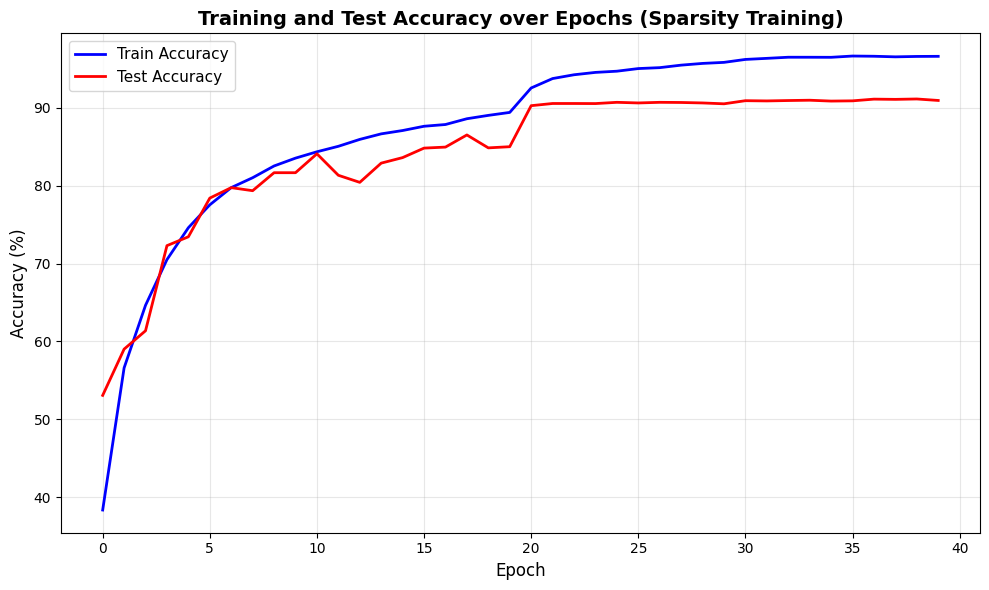

Final Training Accuracy: 96.63%
Final Test Accuracy: 90.96%
Best Test Accuracy: 91.15%


In [17]:
#繪製 Sparsity-Training 結果圖
import matplotlib.pyplot as plt

# 繪製訓練和測試準確率曲線
plt.figure(figsize=(10, 6))
epochs_range = range(START_EPOCH, START_EPOCH + len(train_acc_history))

plt.plot(epochs_range, [acc * 100 for acc in train_acc_history], 'b-', label='Train Accuracy', linewidth=2)
plt.plot(epochs_range, [acc * 100 for acc in test_acc_history], 'r-', label='Test Accuracy', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Training and Test Accuracy over Epochs (Sparsity Training)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
save_path = os.path.join(FIGURE_DIR, 'sparsity_training_accuracy.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✅ Figure saved: {save_path}")
plt.show()

print(f'Final Training Accuracy: {train_acc_history[-1]*100:.2f}%')
print(f'Final Test Accuracy: {test_acc_history[-1]*100:.2f}%')
print(f'Best Test Accuracy: {max(test_acc_history)*100:.2f}%')


## 繪製scaling factor 分布圖

✅ Figure saved: figures/scaling_factor_distribution_lambda_1e-4.png


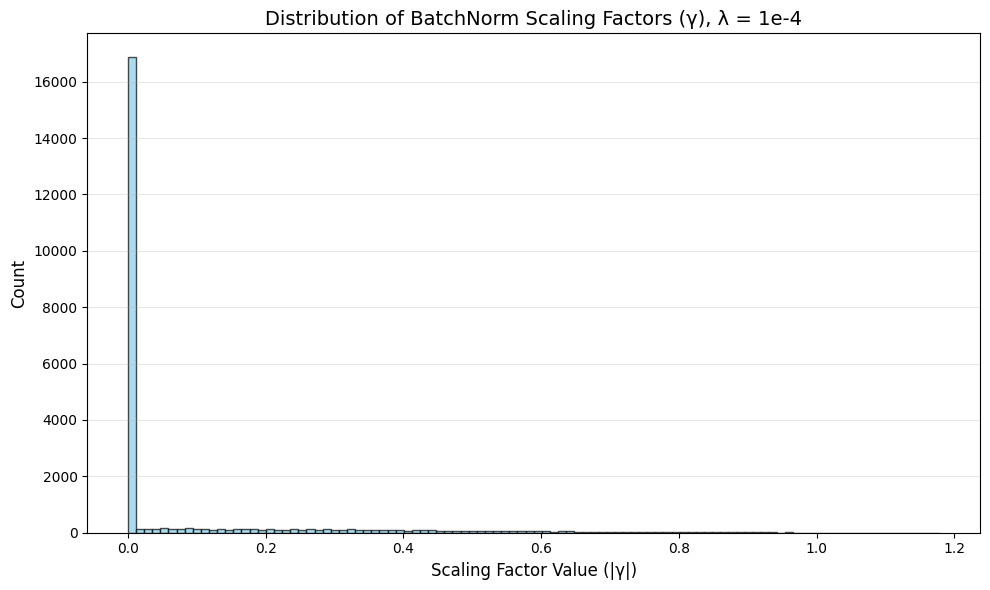

In [ ]:
#繪製 scaling factor 分布圖
import numpy as np

# 收集所有 BatchNorm 層的 scaling factor (gamma/weight)
bn_weights = []
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        # 只收集有 weight 參數的層（跳過 affine=False 的層）
        if m.weight is not None:
            bn_weights.extend(m.weight.data.abs().cpu().numpy())

bn_weights = np.array(bn_weights)

# 繪製 scaling factor 的分布直方圖（單一圖表）
plt.figure(figsize=(10, 6))
plt.hist(bn_weights, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Scaling Factor Value (|γ|)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of BatchNorm Scaling Factors (γ), λ = 1e-4', fontsize=14)  # 修正標題為 1e-4
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
save_path = os.path.join(FIGURE_DIR, 'scaling_factor_distribution_lambda_1e-4.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved: {save_path}")
plt.show()


---

# 📊 額外實驗: 不同 λ 值對比

以下訓練其他 λ 值的模型,用於對比不同稀疏程度的效果


In [17]:
## 訓練 λ = 1e-5 的模型 (對比實驗)

# 設定 lambda 值和保存路徑
LAMBDA_NEW = 1e-5
WEIGHT_PATH_NEW = '/home/twccjq88/2025EAI_Project/EAI_Lab2/checkpoints/model_lambda_1e-5.pth'

print("="*70)
print(f"Training with Lambda = {LAMBDA_NEW}")
print("="*70)

# 重新初始化模型
model = ResNet50(num_classes=10)
if CUDA:
    model = model.cuda()
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# 更新 updateBN 函數使用新的 lambda
def updateBN_new():
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            if m.weight is not None and m.weight.grad is not None:
                m.weight.grad.data.add_(LAMBDA_NEW * torch.sign(m.weight.data))

# 訓練歷史記錄
train_acc_history_1e5 = []
train_loss_history_1e5 = []
test_acc_history_1e5 = []
test_loss_history_1e5 = []

best_test_acc = 0.0

for epoch in range(START_EPOCH, EPOCHS):
    # Learning rate schedule
    if epoch in [int(EPOCHS*0.5), int(EPOCHS*0.75)]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
        print(f"\nLearning rate reduced to {param_group['lr']:.2e}\n")
    
    # Train
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        if SPARSITY_REGULARIZATION:
            updateBN_new()  # 使用新的 lambda
        
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        total += target.size(0)
    
    train_acc = correct.item() / float(total)
    train_loss = train_loss / total
    
    # Test
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            if CUDA:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            total += target.size(0)
    
    test_acc = correct.item() / float(total)
    test_loss = test_loss / total
    
    # Record history
    train_acc_history_1e5.append(train_acc)
    train_loss_history_1e5.append(train_loss)
    test_acc_history_1e5.append(test_acc)
    test_loss_history_1e5.append(test_loss)
    
    # Print
    status = "[BEST]" if test_acc > best_test_acc else "      "
    print(f"{status} Epoch {epoch+1:02d}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc*100:6.2f}% | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc*100:6.2f}%")
    
    # Save best
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_test_acc': best_test_acc,
            'optimizer': optimizer.state_dict(),
            'lambda': LAMBDA_NEW,
            'train_acc_history': train_acc_history_1e5,
            'test_acc_history': test_acc_history_1e5,
        }, WEIGHT_PATH_NEW)

print("\n" + "="*70)
print(f"Training Complete! Best Test Accuracy: {best_test_acc*100:.2f}%")
print(f"Model saved to: {WEIGHT_PATH_NEW}")
print("="*70)


Training with Lambda = 1e-05


[BEST] Epoch 01/40 | Train Loss: 1.8417 Acc:  35.82% | Test Loss: 2.1921 Acc:  44.70%
[BEST] Epoch 02/40 | Train Loss: 1.4552 Acc:  48.14% | Test Loss: 1.2561 Acc:  54.84%
[BEST] Epoch 03/40 | Train Loss: 1.1729 Acc:  58.21% | Test Loss: 1.4423 Acc:  60.23%
       Epoch 04/40 | Train Loss: 1.0055 Acc:  64.65% | Test Loss: 2.4059 Acc:  43.15%
       Epoch 05/40 | Train Loss: 1.3588 Acc:  52.17% | Test Loss: 4.5077 Acc:  58.75%
[BEST] Epoch 06/40 | Train Loss: 1.1257 Acc:  60.11% | Test Loss: 2.4073 Acc:  64.14%
[BEST] Epoch 07/40 | Train Loss: 0.9732 Acc:  66.23% | Test Loss: 0.9547 Acc:  66.78%
[BEST] Epoch 08/40 | Train Loss: 0.8735 Acc:  69.32% | Test Loss: 0.8974 Acc:  70.20%
[BEST] Epoch 09/40 | Train Loss: 0.7487 Acc:  73.60% | Test Loss: 0.7302 Acc:  75.24%
[BEST] Epoch 10/40 | Train Loss: 0.6783 Acc:  76.24% | Test Loss: 0.7126 Acc:  75.89%
[BEST] Epoch 11/40 | Train Loss: 0.6237 Acc:  78.20% | Test Loss: 0.6499 Acc:  77.72%
[BEST] Epoch 12/40 | Train Loss: 0.5886 Acc:  79.59% |

In [18]:
## 訓練 λ = 0 的模型 (Baseline, 無稀疏正則化)

# 設定 lambda 值和保存路徑
LAMBDA_NEW = 0
WEIGHT_PATH_NEW = '/home/twccjq88/2025EAI_Project/EAI_Lab2/checkpoints/model_lambda_0.pth'

print("="*70)
print(f"Training with Lambda = {LAMBDA_NEW}")
print("="*70)

# 重新初始化模型
model = ResNet50(num_classes=10)
if CUDA:
    model = model.cuda()
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# 更新 updateBN 函數使用新的 lambda
def updateBN_new():
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            if m.weight is not None and m.weight.grad is not None:
                m.weight.grad.data.add_(LAMBDA_NEW * torch.sign(m.weight.data))

# 訓練歷史記錄
train_acc_history_1e4 = []
train_loss_history_1e4 = []
test_acc_history_1e4 = []
test_loss_history_1e4 = []

best_test_acc = 0.0

for epoch in range(START_EPOCH, EPOCHS):
    # Learning rate schedule
    if epoch in [int(EPOCHS*0.5), int(EPOCHS*0.75)]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
        print(f"\nLearning rate reduced to {param_group['lr']:.2e}\n")
    
    # Train
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        if SPARSITY_REGULARIZATION:
            updateBN_new()  # 使用新的 lambda
        
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        total += target.size(0)
    
    train_acc = correct.item() / float(total)
    train_loss = train_loss / total
    
    # Test
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            if CUDA:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            total += target.size(0)
    
    test_acc = correct.item() / float(total)
    test_loss = test_loss / total
    
    # Record history
    train_acc_history_1e4.append(train_acc)
    train_loss_history_1e4.append(train_loss)
    test_acc_history_1e4.append(test_acc)
    test_loss_history_1e4.append(test_loss)
    
    # Print
    status = "[BEST]" if test_acc > best_test_acc else "      "
    print(f"{status} Epoch {epoch+1:02d}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc*100:6.2f}% | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc*100:6.2f}%")
    
    # Save best
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_test_acc': best_test_acc,
            'optimizer': optimizer.state_dict(),
            'lambda': LAMBDA_NEW,
            'train_acc_history': train_acc_history_1e4,
            'test_acc_history': test_acc_history_1e4,
        }, WEIGHT_PATH_NEW)

print("\n" + "="*70)
print(f"Training Complete! Best Test Accuracy: {best_test_acc*100:.2f}%")
print(f"Model saved to: {WEIGHT_PATH_NEW}")
print("="*70)


Training with Lambda = 0
[BEST] Epoch 01/40 | Train Loss: 1.9424 Acc:  32.73% | Test Loss: 2.8481 Acc:  44.58%
[BEST] Epoch 02/40 | Train Loss: 1.4272 Acc:  48.75% | Test Loss: 1.2096 Acc:  57.01%
       Epoch 03/40 | Train Loss: 1.2260 Acc:  56.57% | Test Loss: 3.4022 Acc:  53.71%
       Epoch 04/40 | Train Loss: 1.1144 Acc:  60.73% | Test Loss: 32.2590 Acc:  44.70%
[BEST] Epoch 05/40 | Train Loss: 1.0219 Acc:  63.95% | Test Loss: 2.9884 Acc:  64.76%
       Epoch 06/40 | Train Loss: 0.8824 Acc:  69.07% | Test Loss: 1.9292 Acc:  56.40%
[BEST] Epoch 07/40 | Train Loss: 0.8242 Acc:  71.26% | Test Loss: 0.9882 Acc:  66.30%
[BEST] Epoch 08/40 | Train Loss: 0.8558 Acc:  70.70% | Test Loss: 0.9003 Acc:  68.80%
[BEST] Epoch 09/40 | Train Loss: 1.0483 Acc:  64.22% | Test Loss: 0.8148 Acc:  71.16%
[BEST] Epoch 10/40 | Train Loss: 0.7411 Acc:  74.28% | Test Loss: 0.7312 Acc:  75.16%
[BEST] Epoch 11/40 | Train Loss: 0.6549 Acc:  77.21% | Test Loss: 0.6866 Acc:  76.29%
[BEST] Epoch 12/40 | Train L

## 比較不同 λ 值的訓練結果

繪製不同 λ 值的準確率曲線和 scaling factor 分布，方便比較。


/tmp/ipykernel_233512/3613623783.py:36: UserWarning: Glyph 38988 (\N{CJK UNIFIED IDEOGRAPH-984C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_233512/3613623783.py:36: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_233512/3613623783.py:36: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_233512/3613623783.py:36: UserWarning: Glyph 27714 (\N{CJK UNIFIED IDEOGRAPH-6C42}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_233512/3613623783.py:36: UserWarning: Glyph 23565 (\N{CJK UNIFIED IDEOGRAPH-5C0D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_233512/3613623783.py:36: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_233512/3613623783.py:38: UserWarning: Glyph 38988 (\N{CJK UNIFIED I

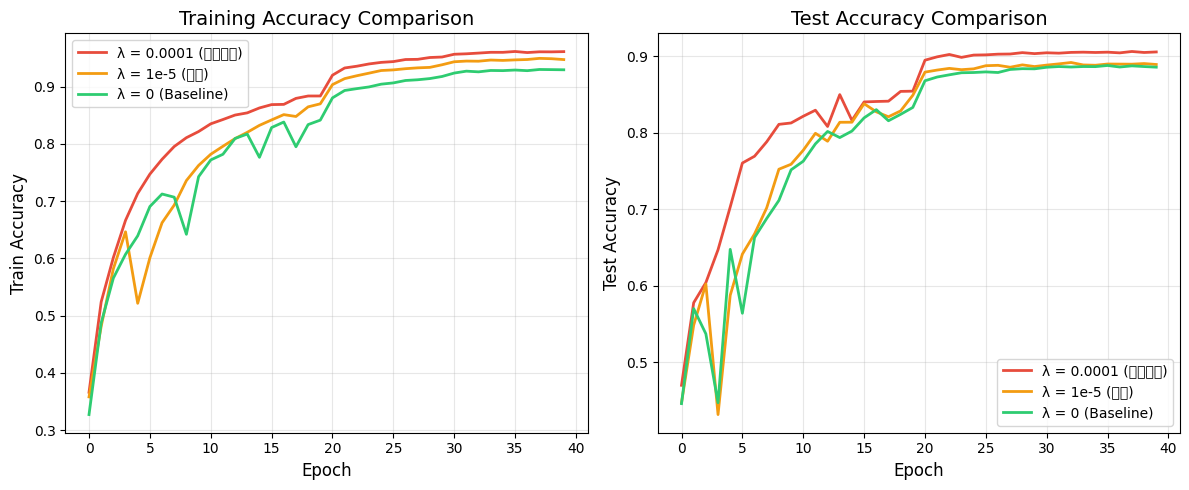

✅ 對比圖已保存: figures/lambda_comparison.png


In [ ]:
# 比較不同 λ 值 (1e-4, 1e-5, 0) 的訓練結果
import matplotlib.pyplot as plt

# 繪製三種不同稀疏程度模型的對比

plt.figure(figsize=(12, 5))

# 子圖1：Train Accuracy
plt.subplot(1, 2, 1)
if 'train_acc_history' in locals():
    plt.plot(train_acc_history, label=f'λ = {LAMBDA} (題目要求)', linewidth=2, color='#e74c3c')
if 'train_acc_history_1e5' in locals():
    plt.plot(train_acc_history_1e5, label='λ = 1e-5 (對比)', linewidth=2, color='#f39c12')
if 'train_acc_history_1e4' in locals():
    plt.plot(train_acc_history_1e4, label='λ = 0 (Baseline)', linewidth=2, color='#2ecc71')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Train Accuracy', fontsize=12)
plt.title('Training Accuracy Comparison', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# 子圖2：Test Accuracy
plt.subplot(1, 2, 2)
if 'test_acc_history' in locals():
    plt.plot(test_acc_history, label=f'λ = {LAMBDA} (題目要求)', linewidth=2, color='#e74c3c')
if 'test_acc_history_1e5' in locals():
    plt.plot(test_acc_history_1e5, label='λ = 1e-5 (對比)', linewidth=2, color='#f39c12')
if 'test_acc_history_1e4' in locals():
    plt.plot(test_acc_history_1e4, label='λ = 0 (Baseline)', linewidth=2, color='#2ecc71')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Test Accuracy Comparison', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
save_path = os.path.join(FIGURE_DIR, 'lambda_comparison.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Comparison plot has been saved: {save_path}")


## Scaling Factor 分布圖 (λ = 1e-5)


/tmp/ipykernel_233512/1860630753.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_1e5 = torch.load('/home/twccjq88/2025EAI_Project/EAI_Lab2/checkpoints/model_l

✅ 圖片已保存: figures/scaling_factor_distribution_lambda_1e-5.png


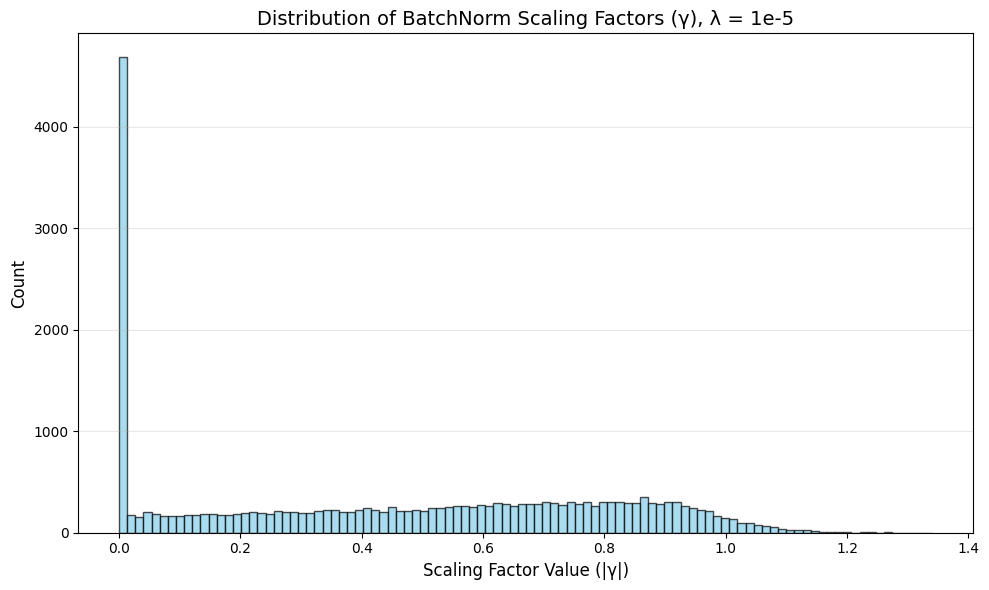

In [ ]:
# 繪製 scaling factor 分布圖 (λ = 1e-5)
import numpy as np
from collections import OrderedDict

# 載入 λ = 1e-5 的模型
checkpoint_1e5 = torch.load('/home/twccjq88/2025EAI_Project/EAI_Lab2/checkpoints/model_lambda_1e-5.pth')
state_dict_1e5 = checkpoint_1e5['state_dict']
clean_state_dict_1e5 = OrderedDict()
for k, v in state_dict_1e5.items():
    key = k.replace('module.', '', 1) if k.startswith('module.') else k
    clean_state_dict_1e5[key] = v

model_1e5 = ResNet50(num_classes=10)
model_1e5.load_state_dict(clean_state_dict_1e5)
if CUDA:
    model_1e5.cuda()

# 收集所有 BatchNorm 層的 scaling factor (gamma/weight)
bn_weights_1e5 = []
for m in model_1e5.modules():
    if isinstance(m, nn.BatchNorm2d):
        # 只收集有 weight 參數的層（跳過 affine=False 的層）
        if m.weight is not None:
            bn_weights_1e5.extend(m.weight.data.abs().cpu().numpy())

bn_weights_1e5 = np.array(bn_weights_1e5)

# 繪製 scaling factor 的分布直方圖（單一圖表）
plt.figure(figsize=(10, 6))
plt.hist(bn_weights_1e5, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Scaling Factor Value (|γ|)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title(f'Distribution of BatchNorm Scaling Factors (γ), λ = 1e-5', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
save_path = os.path.join(FIGURE_DIR, 'scaling_factor_distribution_lambda_1e-5.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Image saved: {save_path}")
plt.show()


## Scaling Factor 分布圖 (λ = 1e-4)


/tmp/ipykernel_233512/2384363042.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_1e4 = torch.load('/home/twccjq88/2025EAI_Project/EAI_Lab2/checkpoints/model_l

✅ 圖片已保存: figures/scaling_factor_distribution_lambda_0.png


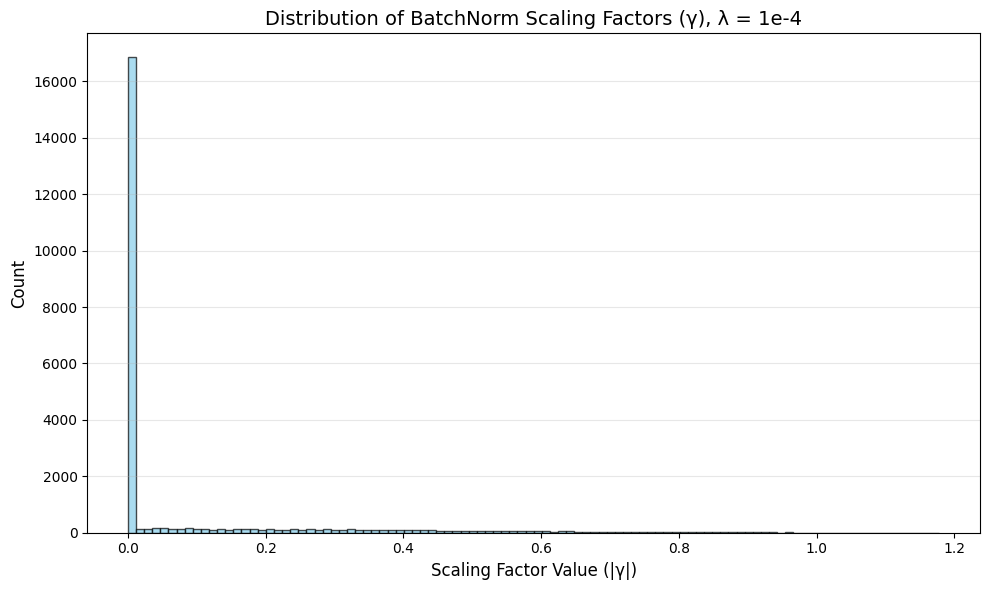

In [ ]:
# 繪製 scaling factor 分布圖 (λ = 1e-4)
import numpy as np
from collections import OrderedDict

# 載入 λ = 1e-4 的模型
checkpoint_1e4 = torch.load('/home/twccjq88/2025EAI_Project/EAI_Lab2/checkpoints/model_lambda_1e-4.pth')
state_dict_1e4 = checkpoint_1e4['state_dict']
clean_state_dict_1e4 = OrderedDict()
for k, v in state_dict_1e4.items():
    key = k.replace('module.', '', 1) if k.startswith('module.') else k
    clean_state_dict_1e4[key] = v

model_1e4 = ResNet50(num_classes=10)
model_1e4.load_state_dict(clean_state_dict_1e4)
if CUDA:
    model_1e4.cuda()

# 收集所有 BatchNorm 層的 scaling factor (gamma/weight)
bn_weights_1e4 = []
for m in model_1e4.modules():
    if isinstance(m, nn.BatchNorm2d):
        # 只收集有 weight 參數的層（跳過 affine=False 的層）
        if m.weight is not None:
            bn_weights_1e4.extend(m.weight.data.abs().cpu().numpy())

bn_weights_1e4 = np.array(bn_weights_1e4)

# 繪製 scaling factor 的分布直方圖（單一圖表）
plt.figure(figsize=(10, 6))
plt.hist(bn_weights_1e4, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Scaling Factor Value (|γ|)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title(f'Distribution of BatchNorm Scaling Factors (γ), λ = 1e-4', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
save_path = os.path.join(FIGURE_DIR, 'scaling_factor_distribution_lambda_1e-4.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Image saved: {save_path}")
plt.show()


## Scaling Factor 分布圖 (λ = 0)


/tmp/ipykernel_233512/3144615501.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_0 = torch.load('/home/twccjq88/2025EAI_Project/EAI_Lab2/checkpoints/model_lam

✅ 圖片已保存: figures/scaling_factor_distribution_lambda_0.png


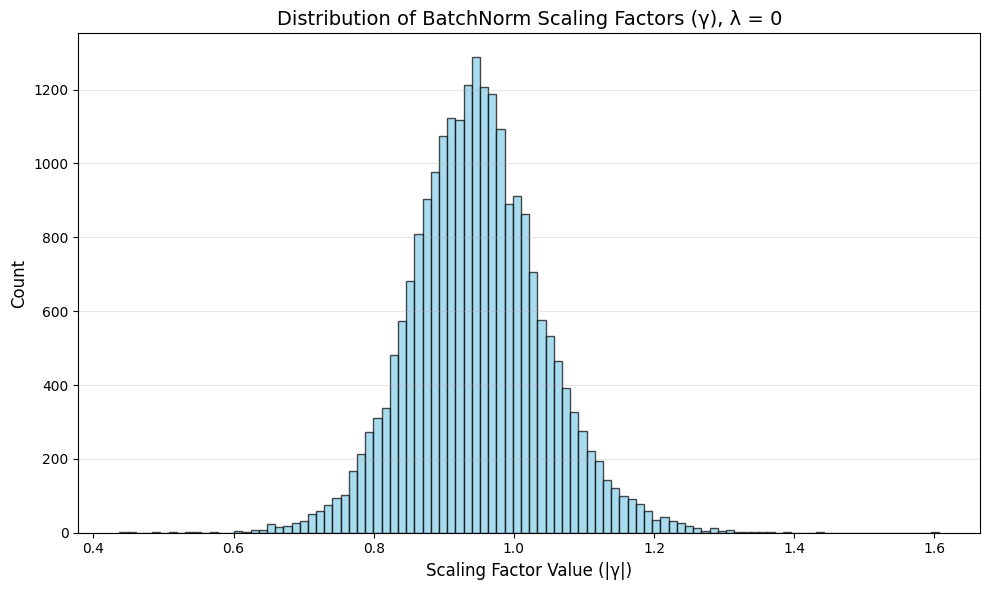

In [ ]:
# 繪製 scaling factor 分布圖 (λ = 0)
import numpy as np
from collections import OrderedDict

checkpoint_0 = torch.load('/home/twccjq88/2025EAI_Project/EAI_Lab2/checkpoints/model_lambda_0.pth')
state_dict_0 = checkpoint_0['state_dict']
clean_state_dict_0 = OrderedDict()
for k, v in state_dict_0.items():
    key = k.replace('module.', '', 1) if k.startswith('module.') else k
    clean_state_dict_0[key] = v

model_0 = ResNet50(num_classes=10)
model_0.load_state_dict(clean_state_dict_0)
if CUDA:
    model_0.cuda()

bn_weights_0 = []
for m in model_0.modules():
    if isinstance(m, nn.BatchNorm2d):
        if m.weight is not None:
            bn_weights_0.extend(m.weight.data.abs().cpu().numpy())

bn_weights_0 = np.array(bn_weights_0)

plt.figure(figsize=(10, 6))
plt.hist(bn_weights_0, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Scaling Factor Value (|γ|)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of BatchNorm Scaling Factors (γ), λ = 0', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
save_path = os.path.join(FIGURE_DIR, 'scaling_factor_distribution_lambda_0.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Image saved: {save_path}")
plt.show()

